# Read and Parse Data

In [8]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

data from: http://api.bitcoincharts.com/v1/csv/

In [9]:
bitcoin_series = pd.read_csv('localbtcAUD.csv')
bitcoin_series.columns = ['datetime', 'price','volum']
bitcoin_series['datetime'] = pd.to_datetime(bitcoin_series['datetime'], unit='s')
bitcoin_series['date'] = bitcoin_series['datetime'].dt.date
# transfer unit from seconds to days
# day,sec = str(bitcoin_series['datetime']).split(' ')
# bitcoin_series['datetime'] = bitcoin_series['datetime'].iloc[:, 0:9]
bitcoin_series.head()

,datetime,price,volum,date
0,2013-03-12 04:30:52,41.38,2.0002,2013-03-12
1,2013-03-12 04:33:31,55.65,4.4927,2013-03-12
2,2013-03-12 04:45:15,51.00,4.5095,2013-03-12
3,2013-03-12 07:20:30,47.56,0.5046,2013-03-12
4,2013-03-12 07:26:03,48.33,1.5700,2013-03-12


# create second dataset based on days

In [4]:
bitcoin_series_2 = bitcoin_series[['date','price']].groupby(['date']).agg(['min','mean','max'], axis='columns').reset_index()
bitcoin_series_2.columns = ['date','min_price','mean_price','max_price']
bitcoin_series_2.head()

,date,min_price,mean_price,max_price
0,2013-03-12,41.38,48.092632,57.12
1,2013-03-13,47.90,50.885385,59.14
2,2013-03-14,49.70,51.500000,58.40
3,2013-03-15,51.74,55.371667,58.82
4,2013-03-16,50.60,52.487273,58.22


# transfer unit from seconds to days

In [5]:
bitcoin_series_2.tail()

,date,min_price,mean_price,max_price
1974,2018-08-08,8180.34,9469.071411,12353.24
1975,2018-08-09,8061.10,9296.004122,19267.45
1976,2018-08-10,8164.43,9476.495949,17642.10
1977,2018-08-11,7721.79,8966.198829,11758.98
1978,2018-08-12,8053.00,9133.581558,12116.15


<font color='red'>！！！why so many differenrt price on same timestamp??? </font>

### transform price from seconds unit to days unit

# Data Visualization

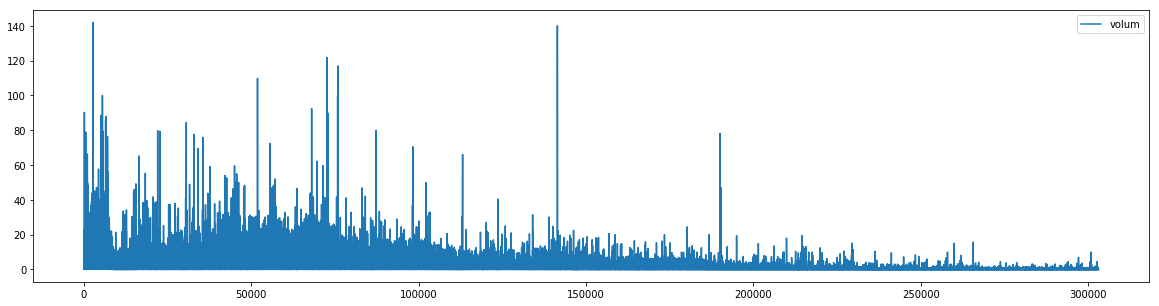

In [7]:
# periods = 96 months, How to use $Y%M as YLable?
bitcoin_series[['volum']].plot(kind='line',figsize=[20,5])

In [6]:
# It seems not corrspond to common sense, usually when volumn is higher, the prive will be higher as well. However, from the figure above, it seems volumn is higher when price is lower.
# So we calculate correlation.
bitcoin_series.corr(method='pearson', min_periods=1)[['price','volum']]

,price,volum
price,1.000000,-0.194008
volum,-0.194008,1.000000


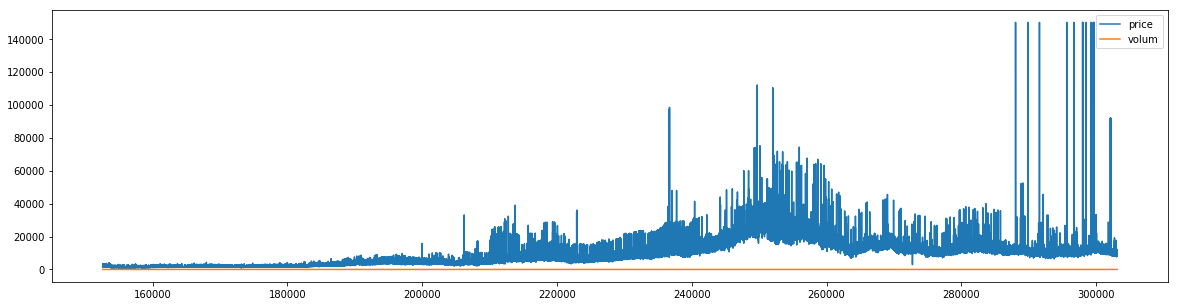

In [7]:
# drill down data to Year 2017-2018
bitcoin_series2 = bitcoin_series[bitcoin_series['datetime']>='2017-01-01']
bitcoin_series2[['price','volum']].plot(kind='line',figsize=[20,5])

In [8]:
# Calculate correlation.
bitcoin_series2.corr(method='pearson', min_periods=1)[['price','volum']]

,price,volum
price,1.000000,-0.180131
volum,-0.180131,1.000000


<font color='red'>！！！heat map </font>

From the above figure and statistical analyse, volun has little contribution to price, so we will not include volum into model later

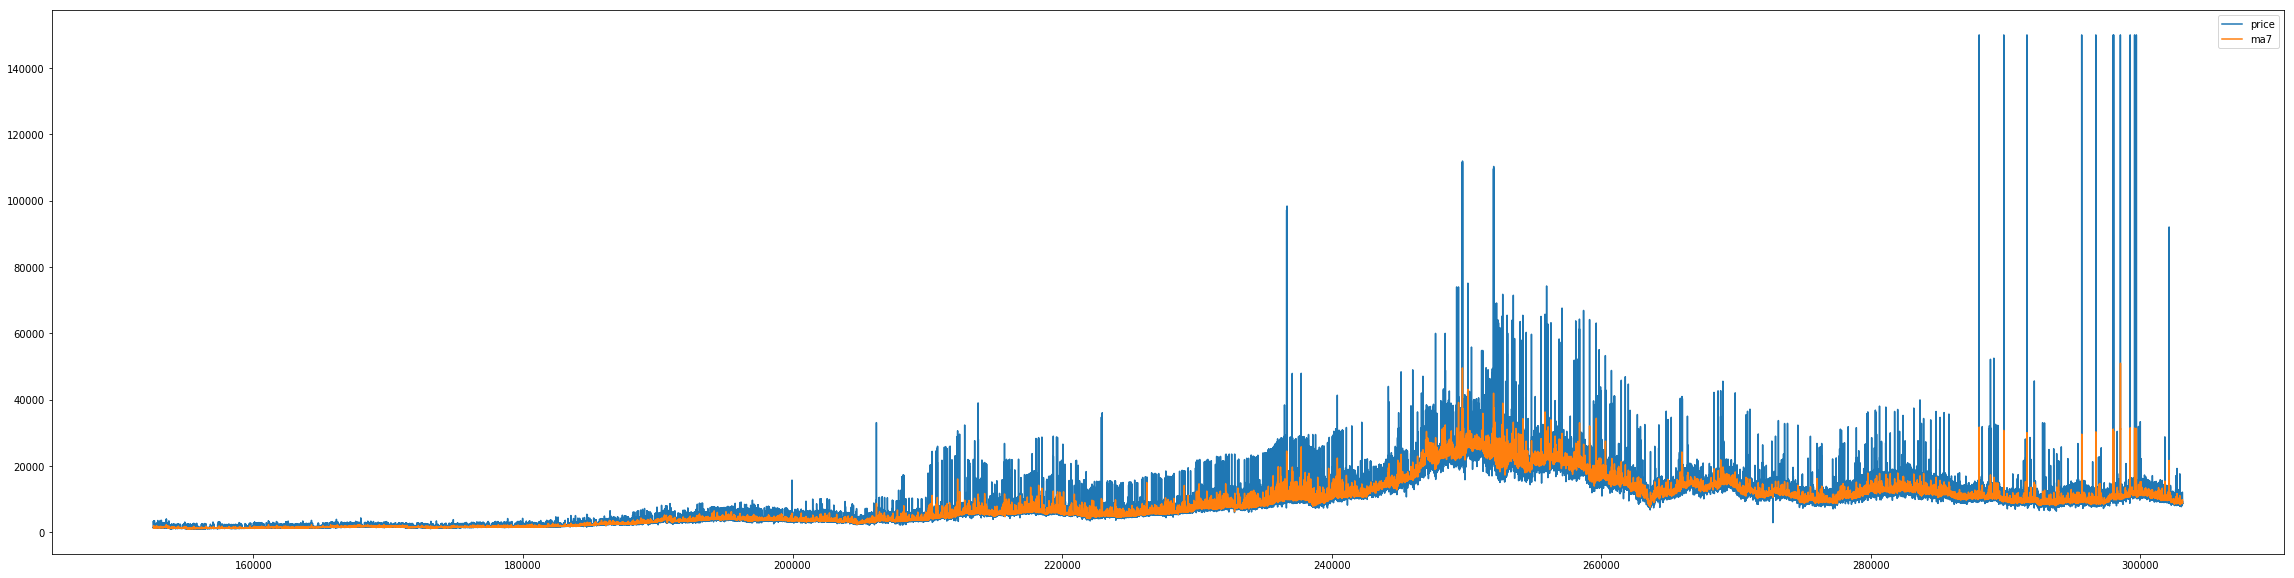

In [9]:
# It is well know that we should use “Seven days average” price to do research and predict, other than everyday price
# If the future price higher than “Seven days average” price, the buyer should sell, vice versa
import warnings; 
warnings.simplefilter('ignore')
bitcoin_series2['ma7'] = bitcoin_series2[['price']].rolling(window=7).mean()
bitcoin_series2[['price','ma7']].plot(kind='line',figsize=[40,10])

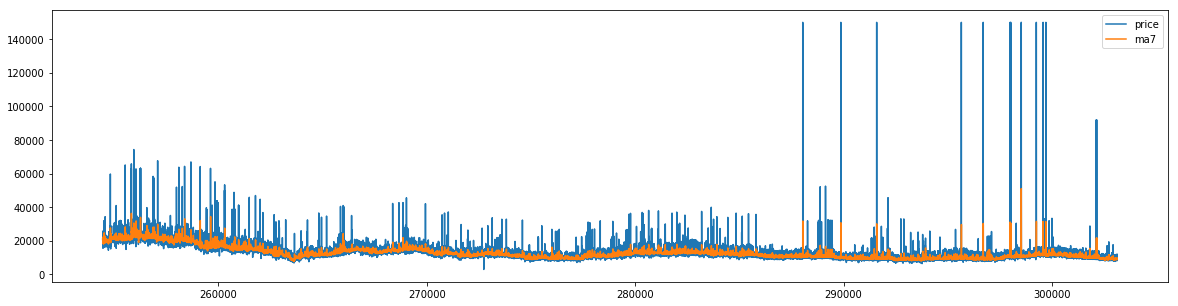

In [10]:
# drill data to the year 2018
bitcoin_series3 = bitcoin_series2[bitcoin_series['datetime']>='2018-01-01']
bitcoin_series3[['price','ma7']].plot(kind='line',figsize=[20,5])

# Stationarity test

we could see that the price fluctuates, but we do not know what reasons cause this fluctuations now
so we have to test whether it is Stationary time series, if yes, we could use ARMA or ARIMA to predict its future prce, 
If not, we have to use other models.

From the figure above, it seems not strict stationarity, so we try 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     
from statsmodels.graphics.tsaplots import plot_acf  #Autocorrelation
from statsmodels.tsa.stattools import adfuller as ADF  #stationary
from statsmodels.graphics.tsaplots import plot_pacf    # partial-autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox    #white noise
from statsmodels.tsa.arima_model import ARIMA

### Autocorrelation

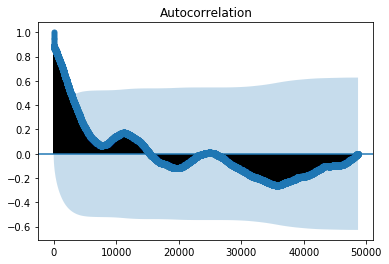

In [12]:
plot_acf(bitcoin_series3['ma7']).show()

Autocorrelation equals to 0 for a relatively long time, so the time series has Strong correlation

### ADF test

ADF： augmented Dickey–Fuller 
https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

In [13]:
print('ADF test Time series from 2018 is', ADF(bitcoin_series3['ma7']))

ADF test Time series from 2018 is (-3.817970565603109, 0.002728712297667888, 56, 48617, {'1%': -3.4304845135508932, '5%': -2.861599452189683, '10%': -2.5668016444407953}, 734373.5081204171)


In [14]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(bitcoin_series3['ma7'])

Test Statistic                    -3.817971
p-value                            0.002729
#Lags Used                        56.000000
Number of Observations Used    48617.000000
Critical Value (1%)               -3.430485
Critical Value (5%)               -2.861599
Critical Value (10%)              -2.566802
dtype: float64

P-value is smaller than 0.01, so it seems like stable

### first difference method

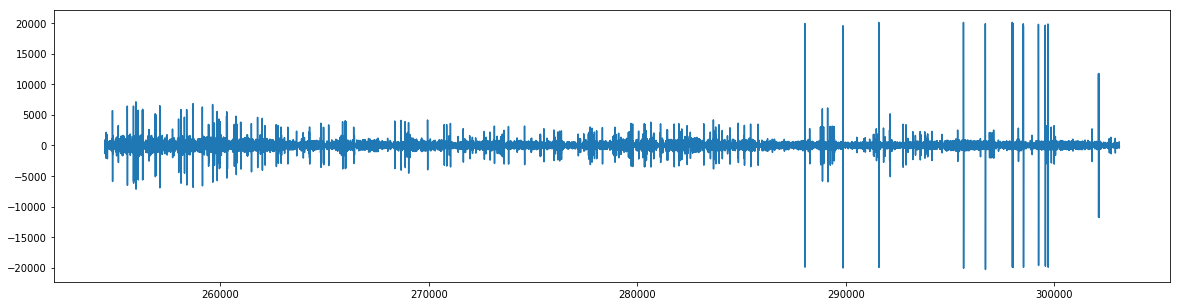

In [15]:
diff1 = bitcoin_series3['ma7'].diff().dropna()
diff1.columns = ['first difference']
diff1.plot(figsize=[20,5])

it seems like the mean of that data is close to 0, but has periodicity too.

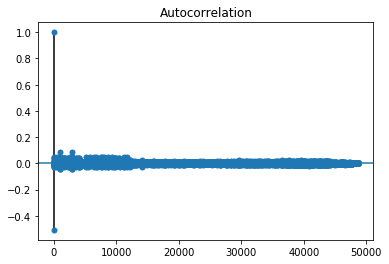

In [16]:
plot_acf(diff1).show()

In [17]:
testStationarity(diff1)

Test Statistic                   -48.888823
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    48617.000000
Critical Value (1%)               -3.430485
Critical Value (5%)               -2.861599
Critical Value (10%)              -2.566802
dtype: float64

### second difference method

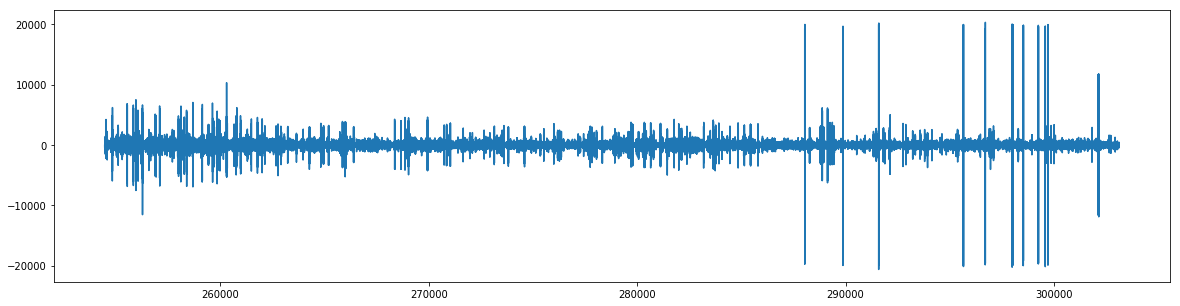

In [18]:
diff2 = diff1.diff().dropna()
diff2.columns = ['Second difference']
diff2.plot(figsize=[20,5])

it seems simliar with first difference method, so we have to do further math test

In [19]:
testStationarity(diff2)

Test Statistic                   -60.695610
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    48614.000000
Critical Value (1%)               -3.430485
Critical Value (5%)               -2.861599
Critical Value (10%)              -2.566802
dtype: float64

### In conlusion, the original price data without differnece method is stationary already, so we could use ARMA and ARIMA models to do further prediction.

### Test

In [ ]:
buy_and_hold(start_date='2013-01-05', end_date='2002-01-03', nshares=100)